# Preparacion del entorno

Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from keras import Sequential
from keras import losses, metrics, optimizers
from keras.applications import mobilenet
from keras.layers import Input, Dense, Conv2D, Flatten, LeakyReLU, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Reshape

import ipynb.fs     #Para importar desde ipynb
import numpy as np
import matplotlib.pyplot as plt
import os

Num GPUs Available:  1


# Preparacion de los datos

In [2]:
from .defs.preparacion_datos import unpickle, tryDataset

(50000, 32, 32, 3)


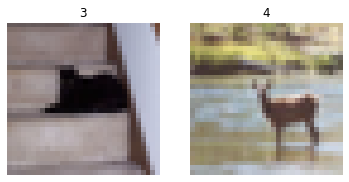

(10000, 32, 32, 3)


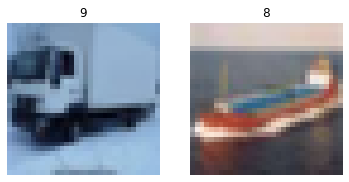

In [3]:
X_train = unpickle("Input\cifar-10-train")
X_test = unpickle("Input\cifar-10-test")
tryDataset(X_train)
tryDataset(X_test)

# Arquitectura del ``Autoencoder``

In [4]:
from .defs.arquitectura import *

# Entrenamiento

## Persistencia

In [5]:
_raiz = "pruebasAAE"
_nombre = "pAAE"

Creamos las carpetas para almacenar el output

In [6]:
def mkfolders(ruta, output=False):
    try:
        os.makedirs(ruta)
    except OSError:
        print("Carpeta %s ya existe" % (ruta))
    if output:
        try:
            os.mkdir(ruta+"/output")
        except OSError:
            print("Carpeta %s ya existe" % (ruta+"/output"))

In [7]:
mkfolders(_raiz, True)

Carpeta pruebasAAE ya existe
Carpeta pruebasAAE/output ya existe


## Funciones de muestreo

In [8]:
def sample_imgs(dataset, model, epoch, sample_size=5, save_imgs=True, show=False, ruta=_raiz, nombre="", title="", output=True):
    # Tomamos sample_size imagenes de muestra
    ids = np.random.randint(0,dataset.shape[0], sample_size)
    sample=dataset[ids]
    # Intentamos regenerar las imagenes
    gen_img = model.predict(sample)[0]
    # Guardamos una grafica con la muestra (arriba) y las imagenes generadas (abajo)
    f, axxs = plt.subplots(2,sample_size)
    if title!="":
        f.suptitle(title+"_"+nombre, fontsize=12)
    for j in range(sample_size):
        axxs[0,j].imshow(sample[j])
        axxs[1,j].imshow(gen_img[j])
    for i in axxs:
        for j in i:
            j.axis("off")
    if save_imgs:
        if output:
            ruta+="/output"
        savefile= ruta+"/"+nombre+"generationCIFAR10_e%d.jpg" % (epoch)
        f.savefig(savefile)
    if show:
        plt.show()
    plt.close()
    

In [9]:
def true_sampler(dim_latente, batch_size):
    return np.random.normal(size=(batch_size, dim_latente))

In [10]:
def generate_samples(dim_latente, decoder, epoch, ruta=_raiz, nombre=_nombre, output=True, show=False):
    sample_shape = (5,5)
    latent_samples = true_sampler(dim_latente, np.prod(sample_shape))
    samples=decoder.predict(latent_samples)#*0.5 +0.5
    fig, axxs = plt.subplots(sample_shape[0], sample_shape[1])
    s=0
    for i in range(sample_shape[0]):
        for j in range(sample_shape[1]):
            axxs[i,j].imshow(samples[s])
            axxs[i,j].axis("off")
            s+=1
    if output:
        ruta+="\output"
    fig.savefig(ruta+"\\"+nombre+"progresscifar10_e%d.png" % (epoch))
    if show:
        print("Imagenes generadas desde el espacio latente:")
        plt.show()
    plt.close()

    

In [11]:
from IPython.display import Image
from IPython.display import display
def show_prevResults(ruta, nombre=_nombre, epochs=5000):
    
    x = Image(filename=ruta+'\\output'+"\\"+nombre+"progresscifar10_e%d.png" % (epochs-1))
    print("Imagenes generadas desde el espacio latente:")
    display(x)

    x = Image(filename=ruta+"\\"+nombre+"progresscifar10_plot.jpg")
    print("Historia del entrenamiento:")
    display(x)

    x = Image(filename=ruta+"/TRAINSETgenerationCIFAR10_e%d.jpg" % (epochs))
    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):") 
    display(x) 
     
    x = Image(filename=ruta+"/TESTSETgenerationCIFAR10_e%d.jpg" % (epochs))         
    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
    display(x)
    

In [12]:
def exploraLatente(encoder, decoder, groupPath, ruta=_raiz, nombre=_nombre):
    groups = unpickle(groupPath)
    
    for key in groups.keys():
        imgs = groups[key]
        latent = []
        size = len(imgs)
        # Obtencion de coordenadas en espacio latente
        #for i in range(size):
        pred = encoder.predict(imgs)
        latent = pred
            #latent.append(pred)
        # Obtenemos la coordenada intermedia
        latent = tf.math.divide(tf.math.add_n(latent),size)
        latent = np.array([latent])
        #Generamos la imagen de esa coordenada
        generated = decoder.predict(latent)

        f, axxs = plt.subplots(1,size+1)
        f.suptitle("Latent aproximation for class "+str(key)+" from " + groupPath, fontsize=12)
        for j in range(size):
            axxs[j].imshow(imgs[j])
            axxs[j].axis("off")
            axxs[j].set_title("Real")
        axxs[size].imshow(generated[0])
        axxs[size].axis("off")
        axxs[size].set_title("Generated")
        plt.show()
        plt.close()
        f.savefig(ruta+"\\"+nombre+" label %d.jpg" % (key))

## Grafica de progreso

In [13]:
def plot_history(history, ruta=_raiz, nombre=_nombre, title=""):
    disc_loss = history[0]
    disc_acc  = history[1]
    aac_loss1 = history[2]
    aac_loss2 = history[3]

    fig, axxs = plt.subplots(1,3)
    if title != "":
        fig.suptitle(title, fontsize=16)

    fig.set_figwidth(24)
    fig.set_figheight(6)

    axxs[0].set_title("Discriminator")
    axxs[1].set_title("Discriminator")
    axxs[2].set_title("AdversarialAutoencoder")

    axxs[0].set_xlabel("Epoch")
    axxs[1].set_xlabel("Epoch")
    axxs[2].set_xlabel("Epoch")

    axxs[0].plot(disc_loss, label = "Loss")
    axxs[1].plot(disc_acc, label = "Accuracy")

    axxs[2].plot(aac_loss1, label = "Loss_decoder")
    axxs[2].plot(aac_loss2, label = "Loss_discriminator")

    axxs[0].legend()
    axxs[1].legend()
    axxs[2].legend()

    fig.savefig(ruta+"\\"+nombre+"progresscifar10_plot.jpg")
    plt.show()
    plt.close()

## Funcion de entrenamiento

In [14]:
def fit_AAE(dim_latente, aae, epochs=12, batch_size=100, sample_interval=100, ruta=_raiz, nombre=_nombre, verbose=True):
    dataset = tf.data.Dataset.from_tensor_slices(X_train)
    dataset = dataset.shuffle(50000, seed=2022)
    dataset = dataset.batch(batch_size)

    history = np.empty([0,4])

    encoder, decoder, discriminator, a_autoencoder=aae
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        print("EPOCH %d" % (epoch))
        for step, imgs in enumerate(dataset):
            #Espacios latentes "reales" y "falsos" para el discriminador
            latent_fake = encoder.predict(imgs)
            latent_true = true_sampler(dim_latente, batch_size)

            #entrenamos el discriminador
            dis_loss_real = discriminator.train_on_batch(latent_true, valid)
            dis_loss_fake = discriminator.train_on_batch(latent_fake, fake)
            dis_avg_loss = 0.5*np.add(dis_loss_fake, dis_loss_real)

            # entrenamos al autoencoder
            aae_loss = a_autoencoder.train_on_batch(imgs,[imgs, valid])
            
            # Guardamos el progreso
            history = np.append(history, [np.append(dis_avg_loss[:2], aae_loss[:2])], axis=0)
            
            # monitorizamos el progreso
            if (step+1) % 10==0 and verbose:
                print("Epoch: %d Step: %d Disc: (loss = %f, acc = %.2f%%) AAE: (mse = %f, b_ce = %f)" % (epoch, step, dis_avg_loss[0], 100*dis_avg_loss[1], aae_loss[0], aae_loss[1]))
            # Hacemos una muestra visual
        generate_samples(dim_latente, decoder, epoch, ruta=ruta, nombre=nombre, show=((epoch+1)==epochs))
    return history.transpose(1,0)

## Entrenamiento en grid

In [15]:
# Temporal
X_train = X_train["data"]
sample_from = X_test["data"]

Tamaño de la capa latente:

In [16]:
dim_latente_cand = [64, 128, 256, 512, 1024]

Tamaño de las imagenes:

In [17]:
img_shape = X_train[0].shape

Parametros:

In [18]:
encoders = [(build_dense_encoder, "dense_enc"), (build_transf_encoder,"transf_enc"), (build_conv_encoder,"conv_enc")]
decoders = [(build_dense_decoder,"dense_dec"), (build_conv_decoder,"conv_dec")]
discriminators = [(build_discriminator ,"default_disc")]
ae_losses = [(losses.mean_squared_error, "ae_MSE_loss"), (EMD_loss, "ae_EMD_loss")]
disc_losses =[(losses.binary_crossentropy, "disc_binXentropy_loss")]

In [19]:
dim_latente_cand = [64]                         # para que las pruebas no tarden 2 horas
encoders = [(build_dense_encoder, "dense_enc")] # para que las pruebas no tarden 2 horas
decoders = [(build_dense_decoder,"dense_dec")]  # para que las pruebas no tarden 2 horas

for z in dim_latente_cand:
    ruta = _raiz+"\z"+str(z)
    mkfolders(ruta, True)
    aae = assemble_AAE(z,img_shape)
    history = fit_AAE(z, aae, ruta=ruta, epochs=100)
    plot_history(history, ruta=ruta)
    

Layers for input 64 and output 1:
Layer 1: 16 neurons
Layer 2: 4 neurons
Layers for input 3072 and output 64:
Layer 1: 845 neurons
Layer 2: 233 neurons
Layers for input 64 and output 3072:
Layer 1: 233 neurons
Layer 2: 845 neurons
EPOCH 0
Epoch: 0 Step: 9 Disc: (loss = 1.763316, acc = 21.00%) AAE: (mse = 0.066022, b_ce = 0.065963)
Epoch: 0 Step: 19 Disc: (loss = 1.599397, acc = 19.50%) AAE: (mse = 0.053563, b_ce = 0.053429)
Epoch: 0 Step: 29 Disc: (loss = 1.327991, acc = 20.50%) AAE: (mse = 0.049079, b_ce = 0.048874)
Epoch: 0 Step: 39 Disc: (loss = 1.084584, acc = 18.00%) AAE: (mse = 0.049745, b_ce = 0.049328)
Epoch: 0 Step: 49 Disc: (loss = 0.914665, acc = 25.50%) AAE: (mse = 0.043489, b_ce = 0.042912)
Epoch: 0 Step: 59 Disc: (loss = 0.834645, acc = 33.00%) AAE: (mse = 0.039332, b_ce = 0.038674)
Epoch: 0 Step: 69 Disc: (loss = 0.742978, acc = 47.00%) AAE: (mse = 0.041651, b_ce = 0.040806)
Epoch: 0 Step: 79 Disc: (loss = 0.619405, acc = 68.00%) AAE: (mse = 0.040681, b_ce = 0.039537)
Ep

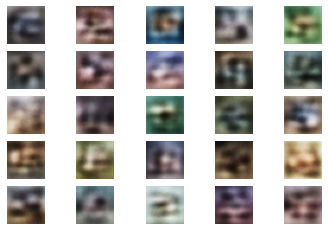

Historia del entrenamiento:


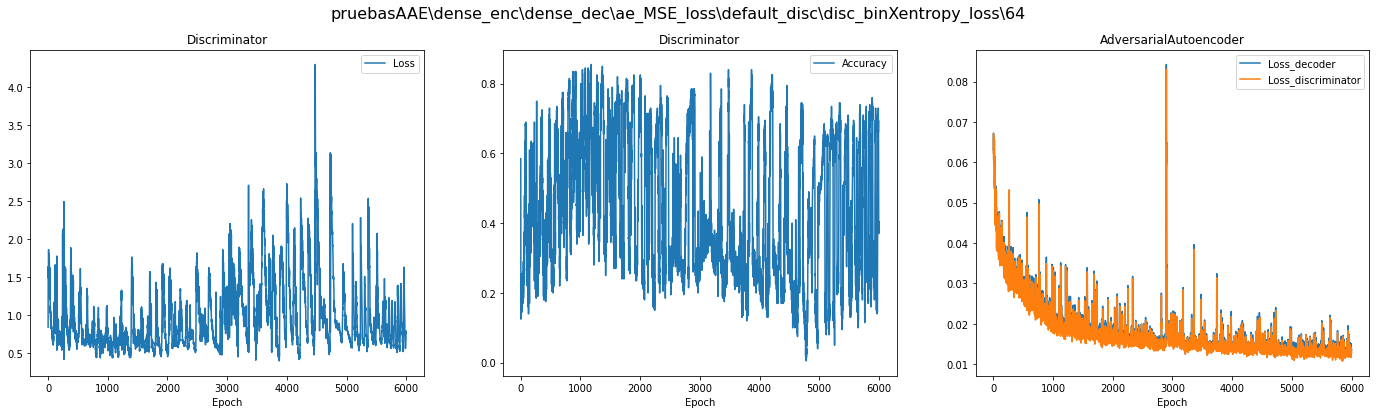

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


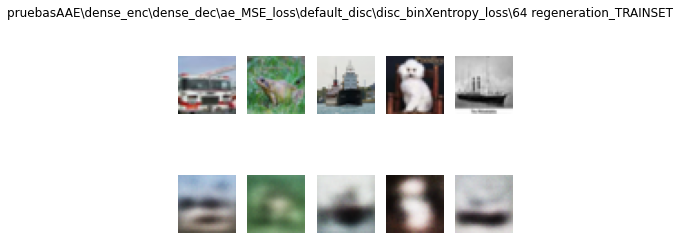

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


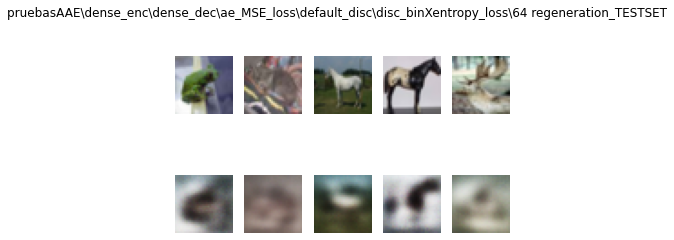

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


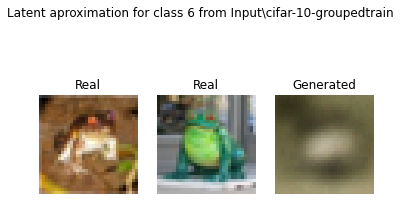

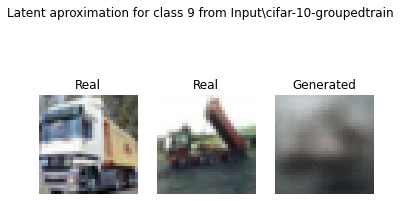

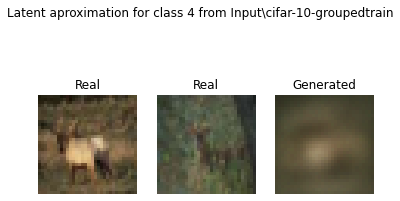

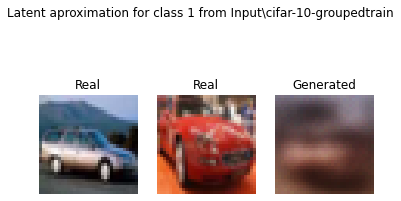

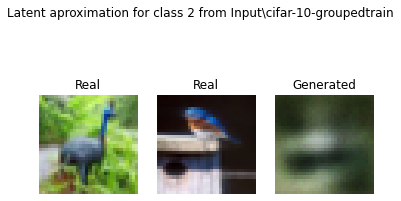

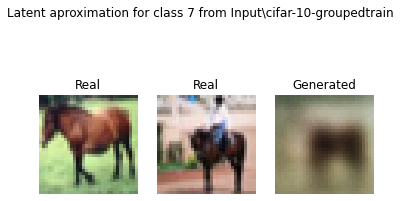

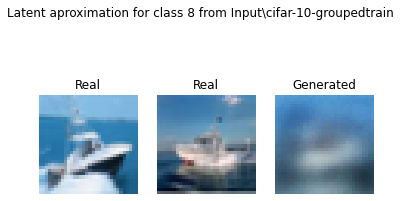

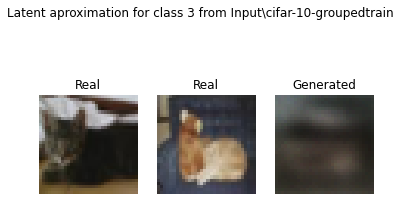

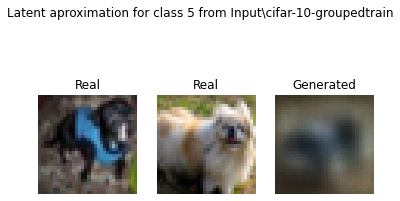

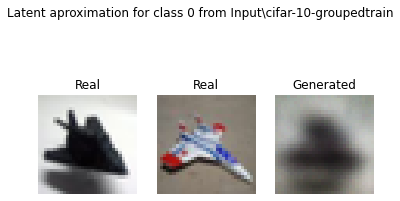

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


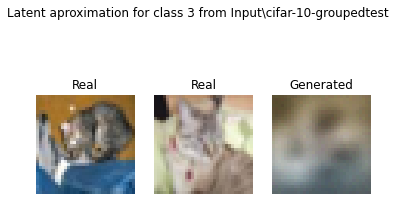

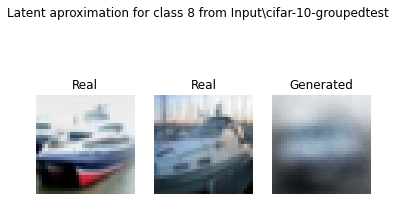

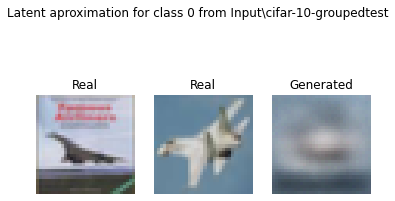

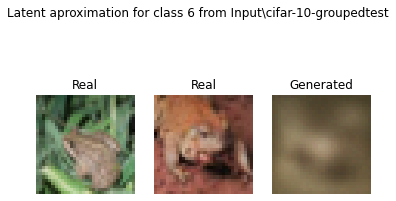

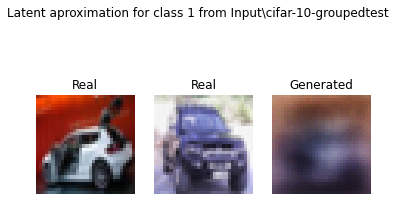

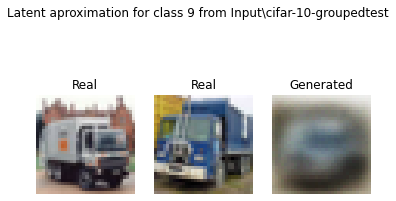

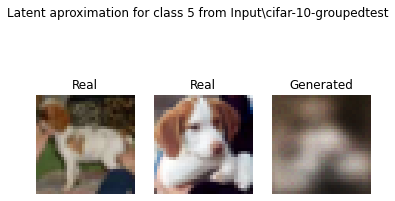

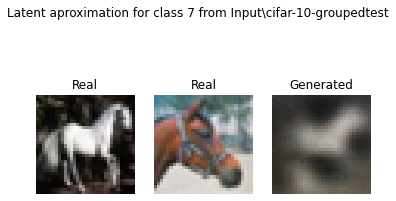

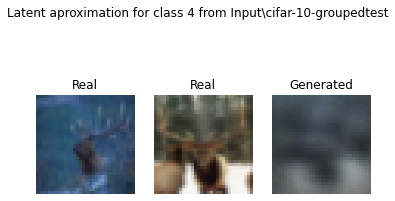

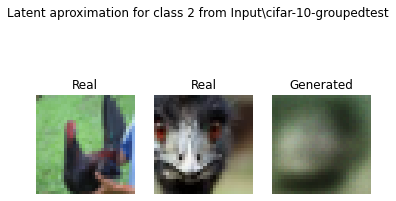

Layers for input 64 and output 1:
Layer 1: 16 neurons
Layer 2: 4 neurons
Layers for input 3072 and output 64:
Layer 1: 845 neurons
Layer 2: 233 neurons
Layers for input 64 and output 3072:
Layer 1: 233 neurons
Layer 2: 845 neurons
EPOCH 0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 1)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch: 0 Step: 9 Disc: (loss = 4.219431, acc = 31.50%) AAE: (mse = 0.266042, b_ce = 0.266305)
Epoch: 0 Step: 19 Disc: (loss = 2.375296, acc =

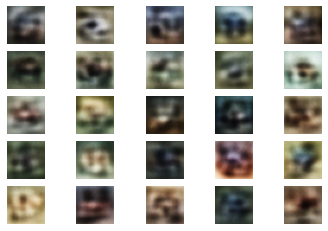

Historia del entrenamiento:


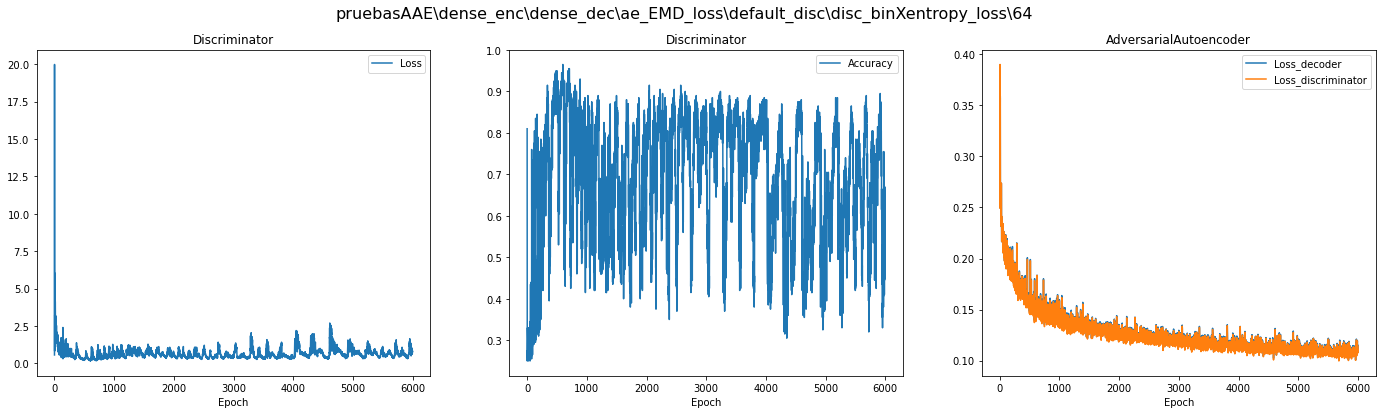

Imagenes regeneradas desde el set de entrenamiento (arriba originales):


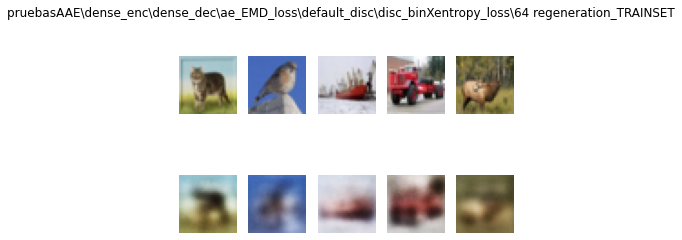

Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):


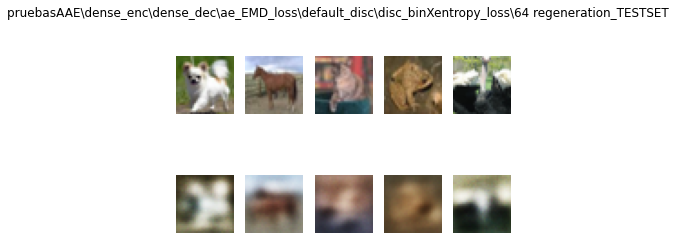

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):


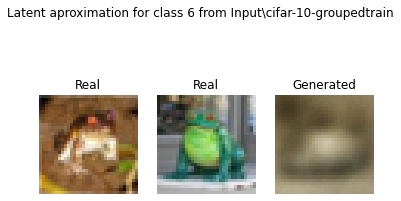

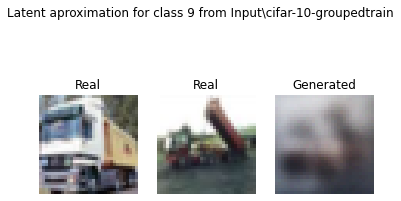

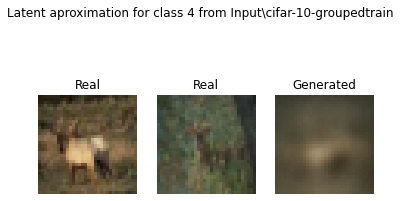

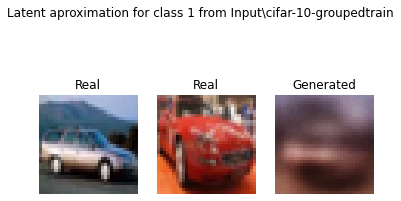

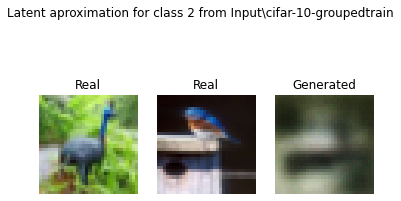

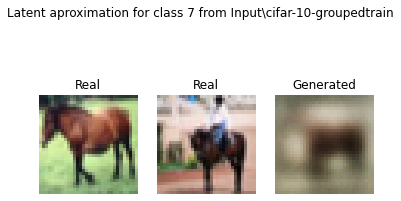

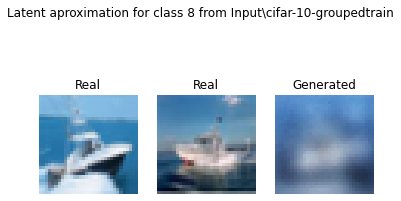

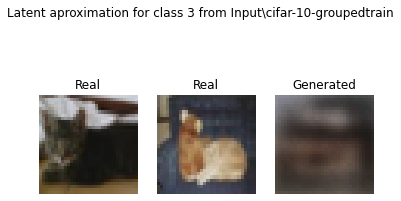

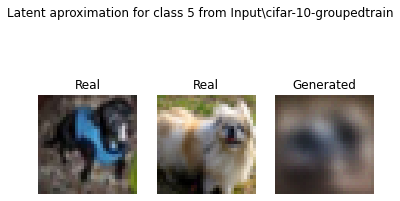

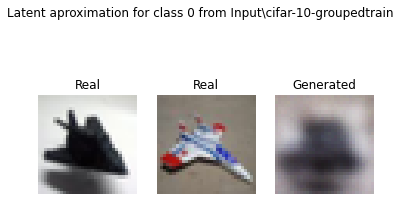

Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):


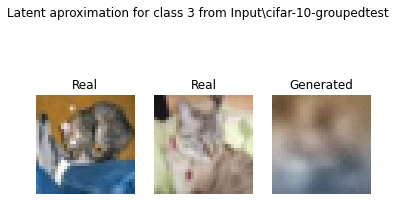

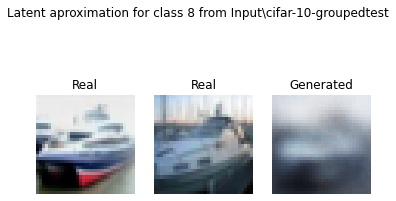

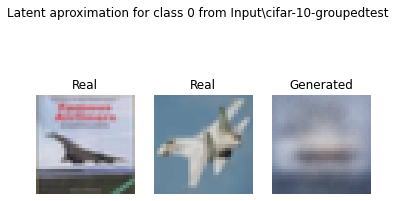

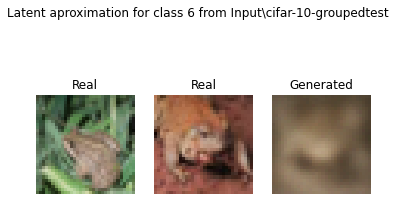

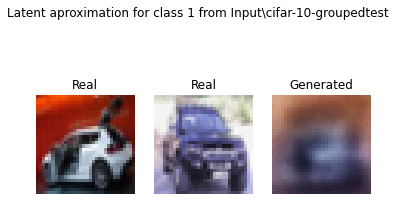

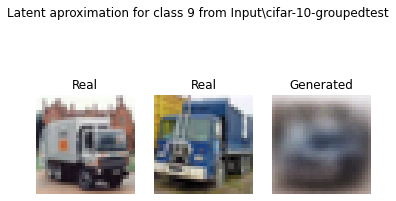

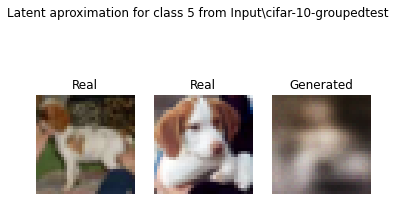

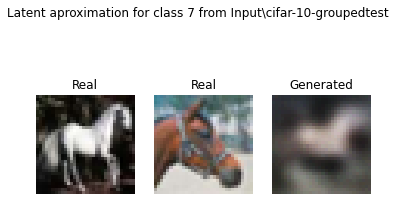

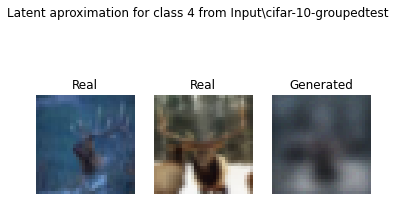

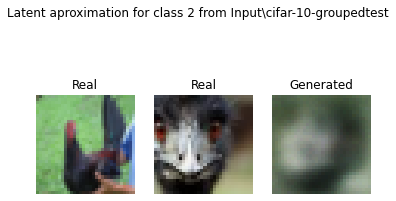

In [20]:
epochs = 12

for enc in encoders:
    for dec in decoders:
        for ae_loss in ae_losses:
            for disc in discriminators:
                for disc_loss in disc_losses:
                    for dim_latente in dim_latente_cand:
                        ruta = _raiz+"\\"+enc[1]+"\\"+dec[1]+"\\"+ae_loss[1]+"\\"+disc[1]+"\\"+disc_loss[1]+"\\"+str(dim_latente)
                        if os.path.isfile(ruta+"\\decoder.h5"):
                            print(ruta+" ya ha sido entrenada")
                            show_prevResults(ruta, epochs=epochs)
                            continue
                        mkfolders(ruta, True)
                        aae = assemble_AAE(dim_latente, img_shape, enc_model = enc[0], dec_model = dec[0], disc_model = disc[0], 
                                           ae_loss = ae_loss[0], disc_loss=disc_loss[0])
                        history = fit_AAE(dim_latente, aae, epochs=epochs, ruta = ruta)
                        print("Historia del entrenamiento:")
                        plot_history(history, ruta=ruta, title=ruta)
                        (encoder, decoder, _, autoencoder) = aae
                        print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):")
                        sample_imgs(X_train, autoencoder, epoch=epochs, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TRAINSET",output=False)
                        print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
                        sample_imgs(sample_from, autoencoder, epoch=epochs, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TESTSET",output=False)
                        print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Train):")
                        exploraLatente(encoder, decoder, "Input\cifar-10-groupedtrain", ruta=ruta, nombre="GenFromLatentTRAINSET")
                        print("Imagenes generadas desde una aproximacion a coordenadas del espacio latente (Test):")
                        exploraLatente(encoder, decoder, "Input\cifar-10-groupedtest", ruta=ruta, nombre="GenFromLatentTESTSET")
                        decoder.save(ruta+"\\decoder.h5")
                        autoencoder.save(ruta+"\\autoencoder.h5")